In [1]:
%matplotlib inline
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib as mpl
mpl.style.use("classic")
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pystan
import pickle
import phasekickstan as p
import h5py
import phasekick
from scipy import signal
import pmefm
import lockin
import os
from scipy.optimize import curve_fit, root
from scipy import optimize
from tqdm import tqdm
from collections import OrderedDict

def tdf2data_transformed(t, df, Ndec):
    t_med = np.mean(t, axis=0)[::Ndec]*1e3
    df_med = np.mean(df, axis=0)[::Ndec]
    Npts = t.shape[0]
    df_std = np.std(df, ddof=1, axis=0)[::Ndec]/Npts**0.5
    m = t_med <= 0
    y_neg = df_med[m]
    offset = np.mean(y_neg)
    
    return {'y_neg': y_neg - offset, 't': t_med[~m], 'N_neg':t_med[m].size, 'N': t_med[~m].size,
           'y_neg_err': df_std[m],
           'y': df_med[~m] - offset, 'y_err': df_std[~m], 'offset': offset
            }

def exp2(t, df, ratio, tau):
    return df * ( ratio*(1-np.exp(-t/tau[0])) + (1-ratio)*(1-np.exp(-t/tau[1])))


def root_exp2(df, ratio, tau, df_e, x0=0.):
    return root(lambda t: exp2(t, df, ratio, tau) - df_e, 0.)

def get_approx_tau(gr, ratio=(1-np.exp(-1)), absolute=None, N=1000):

    
    
    tau = p.percentile_func(gr['params/tau'][:])
    df_inf = p.percentile_func(gr['params/df_inf'][:])
    df_ratio = p.percentile_func(gr['params/df_ratio'][:])
    
    df = df_inf(50)
    if absolute is None:
        df_e = df * ratio
    else:
        df_e = absolute
    
    out_min = root_exp2(df_inf(97.5), df_ratio(97.5), tau(2.5), df_e)
    out_max = root_exp2(df_inf(2.5), df_ratio(2.5), tau(97.5), df_e)
    t = np.linspace(out_min['x'][0], out_max['x'][0], N)
    

    Df = p.fh_exp_doub2df(gr, t=t)
    Dfp = p.percentile_func(Df)
    t50 = t[np.argmax(Dfp(50) < df_e)]
    t15 = t[np.argmax(Dfp(15.9) < df_e)]
    t85 = t[np.argmax(Dfp(84.1) < df_e)]
    return t15, t50, t85

def exprisefall(t, tau, tf, ti=0):
    return np.where(t < ti, 0,
             np.where( t < tf,
                      1-np.exp(-(t-ti)/tau),
                      (1-np.exp(-(tf-ti)/tau))*np.exp(-(t-tf)/tau)
        ))

def fir_tau(tau, fs, ratio=None, N=None, T=None):
    if N is not None:
        pass
    elif T is not None:
        N = int(T*fs)
    elif ratio is not None:
        N = int(fs*tau*ratio)
    else:
        raise ValueError("Must specify N or T")
    
    t = np.arange(N)/fs
    h_raw = np.exp(-t/tau)
    return h_raw / sum(h_raw)

def align_labels(axes_list,lim, axis='y'):
    for ax in axes_list:
        t = ax.yaxis.label.get_transform()
        x,y = ax.yaxis.label.get_position()
        ax.yaxis.set_label_coords(lim,y,t)

In [2]:
fh = h5py.File('../data/pk-efm/151217-205912-p3sun-phasekick.h5', 'r')
gr = fh['data/0058']
li = phasekick.gr2lock(gr, 750, 750*4)
li.phase(tf=-0.051)

In [3]:
h = fir_tau(327e-6, 1e6, 10)
h2 = fir_tau(450e-6, 1e6, 10)
h0 = np.ones(1000)/1000.

In [4]:
df_filt = signal.fftconvolve(li('df'), h, mode='full')
df_filt2 = signal.fftconvolve(li('df'), h2, mode='full')
df_filt0 = signal.fftconvolve(li('df'), h0, mode='full')

In [5]:
maxes = ('none', 0)
for ds_name, ds in fh['data'].items():
    tp = ds.attrs['Abrupt BNC565 CantClk.tp tip [s]']
    if tp > maxes[1]:
        maxes = (ds_name, tp)

In [6]:
od = OrderedDict([(ds_name, ds.attrs['Abrupt BNC565 CantClk.tp tip [s]']) for ds_name, ds in fh['data'].items()])

In [7]:
od_sorted = OrderedDict(sorted(od.iteritems(), key=lambda x: x[1]))

In [8]:
ds_mid = od_sorted.items()[36][0]

In [9]:
gr_mid = fh['data'][ds_mid]

In [10]:
i = 52
ds3 = od_sorted.items()[i][0]
tp3 = od_sorted.items()[i][1]*1e3
gr3 = fh['data'][ds3]
li3 = phasekick.gr2lock(gr3, 750, 750*4)
li32 = phasekick.gr2lock(gr3, 750, 750*4)
tp2 = od_sorted.items()[i][1]*1e3
li3.phase(ti=-0.0015, tf=-0.0005)
li32.phase(tf=-0.051)

In [11]:
i2 = 22
ds_mid = od_sorted.items()[i2][0]
gr_mid = fh['data'][ds_mid]
li_mid = phasekick.gr2lock(gr_mid, 750, 750*4)
li_mid2 = phasekick.gr2lock(gr_mid, 750, 750*4)
tp2 = od_sorted.items()[i2][1]*1e3
li_mid.phase(ti=-0.0015, tf=-0.0005)
li_mid2.phase(tf=-0.051)

In [12]:
t1 = gr.attrs['Abrupt BNC565 CantClk.t1 [s]']*1e3
T_before = 0.001
T_after = 0.001
li.phase(ti=-0.002, tf=0)
tp = li.tp * 1e3
f1 = li.f0corr
phi0 = -li.phi[0]
li.phase(ti=tp*1e-3 + 0.001, tf=(tp*1e3+0.003))
f2 = li.f0corr

def fLock(t):
    return np.where( (t>(tp/1e3)) | (t< (li.t[0] + li.t1)), f2, f1)

In [13]:
lock = lockin.FIRStateLockVarF(li.fir, 83, fLock, 0, li.t[0], fs=li.fs)
lock.filt(li.x)
t_lock = lock.get_t()
t_ms = t_lock * 1e3

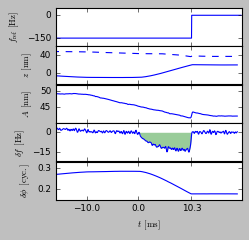

In [18]:
dec = 18
mpl.rc('font', size=8)
with mpl.rc_context({'figure.figsize': (3.0, 3.0)}):
    fig = plt.figure(figsize=(3, 3))
    gs = gridspec.GridSpec(10, 1)
    gs.update(hspace=0.02) # set the spacing between axes. 
    ax1 = fig.add_subplot(gs[0:2])
    ax2 = fig.add_subplot(gs[2:4], sharex=ax1)
    ax3 = fig.add_subplot(gs[4:6], sharex=ax1)
    ax4 = fig.add_subplot(gs[6:8], sharex=ax1)
    ax5 = fig.add_subplot(gs[8:])

    ax1.plot(li.t[::dec]*1000, fLock(li.t[::dec])-f2, linewidth=1)
    ax1.set_ylim(-200, 50)
    ax1.set_yticks([-150, 0])
    ax1.set_ylabel(u'$f_{\\mathrm{ref}} \\: \\: [\\mathrm{Hz}]$')
    
    ax2.plot(t_ms, lock.z_out.real, 'b-', linewidth=1)
    ax2.plot(t_ms, lock.z_out.imag, 'b--', linewidth=1)
    ax2.set_ylabel(u'$z \\: \\: [\\mathrm{nm}]$')
    ax2.set_yticks([0, 40])
    ax2.set_ylim(-25, 61)
    
    phi = np.angle(lock.z_out)/(2*np.pi)
    df = np.gradient(phi) * lock.fs / lock.dec
    ax3.plot(t_ms, abs(lock.z_out))
    ax3.set_yticks(np.arange(45, 50.05, 5))
    ax3.set_ylabel(u"$A \\: \\: [\\mathrm{nm}]$")
    
    ax5.plot(t_ms, phi)
    ax5.set_ylim(0.15, 0.33)
    ax5.set_yticks(np.arange(0.2, 0.35, 0.1))
    ax5.set_ylabel(u'$\\delta \\phi \\: \\: [\\mathrm{cyc.}]$')
    
    line, = ax4.plot(t_ms, df)
    mmm = phasekick.masklh(t_ms, 0, 10.3)
    ax4.fill_between(t_ms[mmm], df[mmm], color='g', alpha=0.4, linewidth=0)
    ax4.set_ylim(-22, 7)
    ax4.set_yticks(np.arange(-15, 5, 15))
    ax4.set_ylabel(u'$\\delta f \\: \\: [\\mathrm{Hz}]$')
    
    
    
    for ax in [ax1, ax5]:
        ax.set_xticks([-50, -10, 0, round(tp, 1)])
        ax.set_xlim(-16, 20)
    
    ax1.set_xticklabels(['', '', ''])
    ax5.set_xlabel(u'$t \\: \\: [\\mathrm{ms}]$')

In [19]:
align_labels([ax1, ax2, ax3, ax4, ax5], 32)

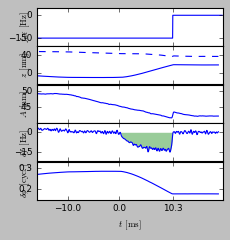

In [20]:
fig

In [21]:
fig.savefig('../figs/02-HL-detailed-workup.pdf', transparent=True, bbox_inches='tight', pad_inches=0.5)

In [33]:
# !cp ex2.pdf /Users/ryandwyer/Dropbox/_JAM_MS__Dwyer201511__Phasekick__figs/raw-figures/02-detailed-workup.pdf